In [1]:
import sys
sys.path.append("/opt/ml/code/")

In [2]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel

import re
import math

import model_encoder

# 데이터 로딩

In [3]:
df = pd.read_json('../../data/wikipedia_documents.json').T

## 중복 데이터 제거

In [4]:
df = df.drop_duplicates(subset=['text'])
df.nunique()

text             56737
corpus_source        1
url                  1
domain               0
title            31726
author               0
html                 0
document_id      56737
dtype: int64

## 데이터 길이 분포 분석

In [5]:
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

In [7]:
def tokenized_len(row):
  return len(tokenizer.tokenize(row))

In [8]:
df['tokenizedCount'] = df['text'].apply(tokenized_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (1131 > 512). Running this sequence through the model will result in indexing errors


<AxesSubplot:xlabel='tokenizedCount', ylabel='Count'>

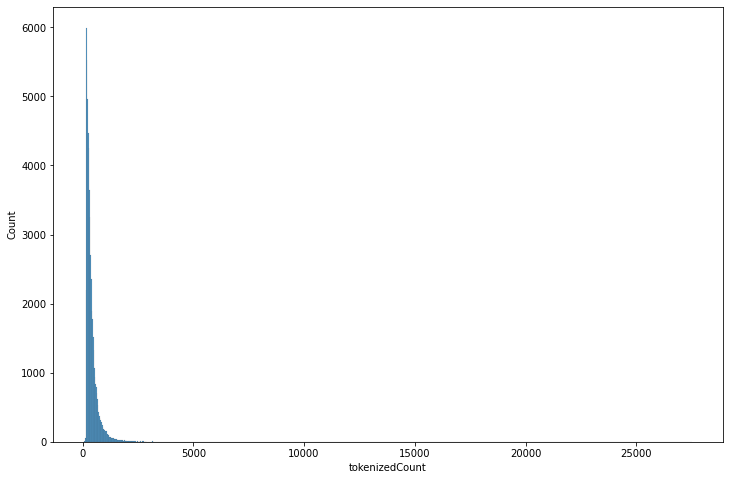

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.histplot(x='tokenizedCount', data=df, bins=1000)

In [10]:
df['tokenizedCount'].describe()

count    56737.000000
mean       401.889208
std        392.152975
min         54.000000
25%        221.000000
50%        308.000000
75%        457.000000
max      27539.000000
Name: tokenizedCount, dtype: float64

# 위키데이터 쪼개기

In [12]:
splited_documents = []
count = 0
for index, document in tqdm(df.iterrows()):
  # print("==================count=====================",count)
  
  original_passage = document['text']

  length_of_tokenized_text = len(tokenizer.tokenize(original_passage))

  number_of_passages_to_create = math.ceil(length_of_tokenized_text / 400)  # 510으로 안하는 이유는 110만큼의 buffer를 주기 위해서
  min_required_length = length_of_tokenized_text // number_of_passages_to_create  # 최소 길이
  max_possible_length = min_required_length + 110  # 최대길이

  end_of_sentences = re.findall(r'[가-힣]+\S*\.', original_passage)
  sentences = re.split(r'[가-힣]+\S*\.', original_passage)
  sentence_counter = 0


  # print(min_required_length)
  for i in range(number_of_passages_to_create):
    partial_text = ''
    partial_text_length = 0

    if sentence_counter == len(end_of_sentences)-1:
      break
    
    for j in range(len(sentences) - 1):
      partial_text += sentences[sentence_counter] + end_of_sentences[sentence_counter]
      partial_text_length += len(tokenizer.tokenize(sentences[sentence_counter] + end_of_sentences[sentence_counter]))
      # print('==============================', sentence_counter, len(sentences)-1, len(end_of_sentences)-1)
      # print(partial_text, partial_text_length)
      sentence_counter += 1
      if partial_text_length >= min_required_length or sentence_counter == len(end_of_sentences)-1:
        
        if sentence_counter == len(end_of_sentences)-1:
          partial_text += sentences[-1]
        document_to_be_added = {
          'text': partial_text,
          'title': document['title'],
          'document_id': count # document['document_id']
        }

        splited_documents.append(document_to_be_added)
        count +=1
        break
print("length of data after split: ", len(splited_documents))

56737it [03:16, 289.35it/s]


## 엘라스틱서치 연결

In [6]:
es = Elasticsearch([{'host': 'localhost', 'port': 9200}])
es.ping()

/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


True

### 인덱스 목록 보기

In [7]:
res = es.indices.get_alias("*")
for Name in res:
  print(Name)

.tasks
wiki_documents_dense_sen_html
wiki_documents_dense
.kibana-event-log-7.15.1-000001
wiki_documents_splited
wiki_documents_splited_dense
.apm-custom-link
.kibana_7.15.1_001
.kibana_task_manager_7.15.1_001
wiki_documents
.apm-agent-configuration
wiki_documents_dense_sen


/tmp/ipykernel_28063/3052314421.py:1: DeprecationWarning: Using positional arguments for APIs is deprecated and will be disabled in 8.0.0. Instead use only keyword arguments for all APIs. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.indices.get_alias("*")
/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: this request accesses system indices: [.tasks, .apm-custom-link, .kibana_7.15.1_001, .kibana_task_manager_7.15.1_001, .apm-agent-configuration], but in a future major version, direct access to system indices will be prevented by default
  warnings.warn(message, category=ElasticsearchWarning)


In [28]:
# 인덱스에 도큐멘트 수 보기
es.count(index = 'wiki_documents_dense')

{'count': 0,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}

### 인덱스 삭제하기

In [ ]:
# es.indices.delete(index='wiki_documents_splited', ignore=[400, 404])

## 쪼깨진 위키데이터 입력

### 쪼갠 위키데이터를 입력하기 위한 제너레이터

In [ ]:
def generator(splited_documents):
  for c, line in enumerate(splited_documents):
    yield {
      '_index': 'wiki_documents_splited',
      '_type': '_doc',
      '_id': line.get('document_id', None),
      '_source': {
        'title': line.get('title', ''),
        'text': line.get('text', '')
      }
    }
  raise StopIteration

In [ ]:
CONFIG = {
  'settings':{
    'number_of_shards':1,
    'number_of_replicas':1,
    'analysis':{
      'analyzer': {
        'nori_analyzer':{
          'type': 'custom',
          'tokenizer': 'nori_tokenizer'
        }
      },
    }
  },
  'mappings':{
    'properties':{
      'title':{
        'type':'text'
      },
      'text':{
        'type':'text',
        "analyzer": "nori_analyzer"
      }
    }
  }
}

In [ ]:
es.indices.create(index='wiki_documents_splited', ignore=[400,404], body=CONFIG)

In [ ]:
gen = generator(splited_documents)
try:
  res = helpers.bulk(es, gen, chunk_size = 1)
  # print(res)
except Exception as e:
  print(e)
  print('Done')

# 쪼갠 위키데이터 Dense Embedding해서 넣기

In [62]:
p_encoder = model_encoder.BertEncoder.from_pretrained('../encoders/p_encoder_neg').to('cuda')

In [63]:
p_embs = []
for document in tqdm(splited_documents):
  with torch.no_grad():
    p_encoder.eval()
    p_val = tokenizer([document['text']], padding="max_length", truncation=True, return_tensors='pt', max_length=510).to('cuda')

    p_emb = p_encoder(**p_val)
    p_embs.append(p_emb[0].cpu().detach().numpy().tolist())
    

100%|██████████| 78411/78411 [20:55<00:00, 62.45it/s]


In [64]:
CONFIG = {
  'settings':{
    'number_of_shards':1,
    'number_of_replicas':1,
    'analysis':{
      'analyzer': {
        'nori_analyzer':{
          'type': 'custom',
          'tokenizer': 'nori_tokenizer'
        }
      },
    }
  },
  'mappings':{
    'properties':{
      'text':{
        'type':'text',
        "analyzer": "nori_analyzer"
      },
      'vector':{
        'type':'dense_vector',
        'dims':768
      }
    }
  }
}

In [65]:
es.indices.delete(index='wiki_documents_splited_dense', ignore=[400, 404])
es.indices.create(index='wiki_documents_splited_dense', ignore=[400,404], body=CONFIG)

/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/tmp/ipykernel_2540/2407913785.py:2: DeprecationWarning: The 'body' parameter is deprecated for the 'create' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.indices.create(index='wiki_documents_splited_dense', ignore=[400,404], body=CONFIG)


{'acknowledged': True,
 'shards_acknowledged': True,
 'index': 'wiki_documents_splited_dense'}

In [66]:
def generator(splited_documents, p_embs):
  for document, vector in zip(splited_documents, p_embs):
    yield {
      '_index': 'wiki_documents_splited_dense',
      '_type': '_doc',
      '_id': document.get('document_id', None),
      '_source': {
        'text': document.get('text', ''),
        'vector': vector
      }
    }
  raise StopIteration

In [67]:
gen = generator(splited_documents, p_embs)
try:
  res = helpers.bulk(es, gen, chunk_size = 1)
  # print(res)
except Exception as e:
  print(e)
  print('Done')

/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchWarning)


generator raised StopIteration
Done


## 검증해보기

In [74]:
q_encoder = model_encoder.BertEncoder.from_pretrained('../encoders/q_encoder_neg').to('cuda')

In [80]:
query = '대한민국의 대통령은 누구인가?'

In [81]:
with torch.no_grad():
  q_encoder.eval()
  q_val = tokenizer([query], padding="max_length", truncation=True, return_tensors='pt', max_length = 510).to('cuda')

  q_emb = q_encoder(**q_val)
  q_output = q_emb[0].cpu().detach().numpy().tolist()

In [97]:
res = es.search(
  index='wiki_documents_splited_dense',
  body={
    'query':{
      "script_score": {
        "query" : {
          "match" : {
            "text": query
          },
        },
        "script": {
          # "source": "1 / (1 + l2norm(params.queryVector, doc['vector']))",
          # "source": "cosineSimilarity(params.queryVector, doc['vector']) + 1.0",
          "source": "_score * cosineSimilarity(params.queryVector, doc['vector']) / (_score + cosineSimilarity(params.queryVector, doc['vector'])) + cosineSimilarity(params.queryVector, doc['vector']) * _score / (_score + cosineSimilarity(params.queryVector, doc['vector']))",
          "params": {
            "queryVector": q_output
          }
        }
      }
    }
  },
  size= 10
)

/tmp/ipykernel_10369/3671833892.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(


In [98]:
for i in range(10):
  print(res['hits']['hits'][i]['_score'])

1.0137191
1.0114226
1.0108639
1.01084
1.0100178
1.00925
1.0047284
1.0042971
1.0031106
1.0029849


In [84]:
for i in range(3):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

 1948년 대한민국 대통령 선거가 1948년 5월 10일 열렸고, 대통령으로 이승만이 선출되었다. 1948년 8월 15일 대한민국 정부가 수립되었고, 9월 9일 조선민주주의인민공화국이 수립되어 김일성이 총리로 임명되었다. 이 두 정부의 출현은 한반도의 분단을 고착화시켰다. 소련군은 1948년 12월 10일 떠났고, 이틀 후 대한민국 정부는 유엔으로부터 한반도 유일의 합법 정부로 인정받았다. 1949년 미군이 한반도를 떠났지만 주한 미군 군사 고문단이 대한민국에 남아있었다. 두 정부는 국명 또한 달랐는데 북측은 조선이라는 국명을 채택했고, 남측은 대한이라는 이름을 채택했다. \n\n두 정부는 서로가 한반도 유일의 정부라고 주장했고, 분단이 일시적인 것이라고 보았다. 김일성은 이오시프 스탈린과 마오쩌둥을 설득해 통일 전쟁을 준비했고, 이승만은 북진에 대한 열망을 포기하지 않았다. 1948년 북한은 남한으로 이어진 전기선을 모두 차단했다. 전쟁이 발발하기 직전까지 옹진군과 개성 일대를 비롯한 38도선 일대에서 국지적 분쟁이 발생했다. \n\n이 시기 동안 여수·순천 사건과 제주 4·3 사건 등 남한에서는 다양한 반란이 일어나 탄압되었다.
워터게이트 당시 미국 공화당 리처드 닉슨 대통령이 자신의 범죄증거가 되는 녹음테이프를 발견한 특별검사를 즉시 해고했다. 이 해임으로 더욱 비난이 거세지자 결국 대통령이 하야하게 되었다. 새로운 대선에서 미국 민주당 지미 카터 대선후보는 대통령이 임명한 특별검사를 대통령이 자의적으로 해고할 수 없도록 신분보장 조항의 입법을 대선공약으로 내걸었다. 대통령으로 당선된 후 1978년 상설특검법을 제정했다.\n\n최순실 특검법도 미국 1978년 상설특검법 처럼, 대통령이 임명한 특별검사를, 대통령이 자의적으로 해고할 수 없는 신분보장 조항을 두고 있다.\n\n대통령은 1) 특검법 제4조의 결격사유, 2) 직무수행이 현저히 곤란한 신체적·정신적 질환이 있는 경우, 3) 형사소송법, 검찰청법, 군사법원법, 그 밖의 법령 중 검사의 의무 위반일

In [85]:
res = es.search(
  index='wiki_documents_splited_dense',
  body={
    'query':{
      "script_score": {
        "query" : {
          "match" : {
            "text": query
          },
        },
        "script": {
          # "source": "1 / (1 + l2norm(params.queryVector, doc['vector']))",
          "source": "cosineSimilarity(params.queryVector, doc['vector']) + 1.0",
          # "source": "_score * cosineSimilarity(params.queryVector, doc['vector']) / (_score + cosineSimilarity(params.queryVector, doc['vector'])) + cosineSimilarity(params.queryVector, doc['vector']) * _score / (_score + cosineSimilarity(params.queryVector, doc['vector']))",
          "params": {
            "queryVector": q_output
          }
        }
      }
    }
  },
  size= 3
)

/tmp/ipykernel_10369/335627280.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(


In [86]:
res

{'took': 241,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': 1.5386305,
  'hits': [{'_index': 'wiki_documents_splited_dense',
    '_type': '_doc',
    '_id': '68402',
    '_score': 1.5386305,
    '_source': {'text': '”라고 하여 ‘호해정-호해지사-호걸지사-호연지기’로까지 논리를 확장시켰다.',
     'vector': [0.6398512125015259,
      -0.5646401643753052,
      0.9436553716659546,
      -0.9263488054275513,
      0.8050285577774048,
      -0.6416405439376831,
      -0.8971000909805298,
      -0.8946242928504944,
      0.9934375286102295,
      -0.46310409903526306,
      -0.5593315362930298,
      0.4915967583656311,
      0.36646634340286255,
      0.1853293627500534,
      0.31924811005592346,
      -0.98371422290802,
      -0.9801313281059265,
      -0.8915809988975525,
      0.9131497740745544,
      0.09017793089151382,
      0.7707889080047607,
      -0.9979203343391418,
      -0.9245787858963013,
  

In [87]:
for i in range(3):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

”라고 하여 ‘호해정-호해지사-호걸지사-호연지기’로까지 논리를 확장시켰다.
 그 외에 정실을 알고도 자수하지 않은 자들은 모두 다 용서한다.
 탐ㆍ진ㆍ치에 의지하는 것으로 말미암는 까닭이다. 올바른 이치에 의지하지 않고 여러 모양에 집착하거나 그 좋아하는 것에 집착하는 것이다."


In [92]:
res = es.search(
  index='wiki_documents_splited_dense', 
  body={
    'query':{
      'match':{
        'text':query,
        # 'tokenizer': 'nori'
      }
    }
  },
  size=3
)

/tmp/ipykernel_10369/3960208950.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(
/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


In [93]:
res

{'took': 7,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': 19.96599,
  'hits': [{'_index': 'wiki_documents_splited_dense',
    '_type': '_doc',
    '_id': '54430',
    '_score': 19.96599,
    '_source': {'text': "2016년 1월 29일자로 일본 산케이 신문 1면기사로 책발간 소식을 알리고 《왜 나는 한국에 승리하였나. 박근혜 정권과의 500일 전쟁》이라는 제목의 책을 발간개시하였다.  책에서 그는 대한민국은 중세 국가와 마찬가지라 하고 대한민국은 대통령과 국민 감정에 따라 자의적으로 법이 해석된다고 했다. 그는 이어서 대한민국 검찰은 박근혜의 동태와 여론의 반응을 살피기 바빴고, 그래서 '과연 대한민국은 민주주의 가치를 공유하며 법치주의를 실천하고 있다고 말할 수 있는가’라며 대한민국을 비난했으며, '오히려 일본을 악의 제국으로 매도하며 대한민국이 일방적인 견해를 시사하고 있는 것 아닌가”라고 했다.",
     'vector': [0.7814743518829346,
      -0.7537798881530762,
      0.9760511517524719,
      -0.9985761642456055,
      0.7579887509346008,
      -0.7456434965133667,
      -0.999424397945404,
      -0.7849445343017578,
      0.9878537654876709,
      -0.9395608901977539,
      -0.5520896911621094,
      0.9268690347671509,
      0

In [91]:
for i in range(3):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

2016년 1월 29일자로 일본 산케이 신문 1면기사로 책발간 소식을 알리고 《왜 나는 한국에 승리하였나. 박근혜 정권과의 500일 전쟁》이라는 제목의 책을 발간개시하였다.  책에서 그는 대한민국은 중세 국가와 마찬가지라 하고 대한민국은 대통령과 국민 감정에 따라 자의적으로 법이 해석된다고 했다. 그는 이어서 대한민국 검찰은 박근혜의 동태와 여론의 반응을 살피기 바빴고, 그래서 '과연 대한민국은 민주주의 가치를 공유하며 법치주의를 실천하고 있다고 말할 수 있는가’라며 대한민국을 비난했으며, '오히려 일본을 악의 제국으로 매도하며 대한민국이 일방적인 견해를 시사하고 있는 것 아닌가”라고 했다.
선거명=|국가=대한민국|유형=대통령|이전선거=대한민국 제18대 대통령 선거 통합진보당 후보 경선|이전선거_연도=2012년|선거일=2017년 3월 21일~25일|차기선거=대한민국 제20대 대통령 선거|차기선거_연도=2022년|투표율=72.11%|정당색=민중연합당|이미지1=|색1=민중연합당|후보1=김선동|정당1=민중연합당|득표수1=9,677|득표율1=95.4%|직책=대통령 후보|선거전=이정희 (1969년) 김선동|선거후_정당=민중연합당|국기_이미지=}}민중연합당 제19대 대통령 후보 선거는 2017년 대한민국 대통령 선거를 위해 민중연합당의 후보를 선출하는 절차를 말한다.
2017년 3월 25일 김선동 전 통합진보당 원내부대표가 민중연합당의 제19대 대통령 후보로 확정되었다.
 

2017년 샤브카트 미르지요예프 대통령은 대한민국과 우즈베키스탄의 25주년 수교를 계기로 국빈으로서 대한민국을 방문하였다. 문재인 대통령은 우즈베키스탄은 중앙아시아의 중심국가이고 유라시아대륙의 심장에 위치하는 국가이며 샤브카트 미르지요예프 대통령은 사람 중심의 정치를 행하는 자신의 국정철학과 닮은 대통령이라고 칭찬하며 앞으로도 양국의 우정이 오래가길 희망한다고 밝혔고 샤브카트 미르지요예프 대통령은 자신의 손녀가 대한민국 거주 경험이 있어 한국말을 잘 한다고 화답하며 한-우즈베키스탄 양국의 오랜 우정

# 쪼개지 않은 문서 임베딩 해서 넣기

In [7]:
# p_encoder = model_encoder.BertEncoder.from_pretrained('../encoders/q_encoder_neg').to('cuda')
p_encoder_sen = model_encoder.RobertaEncoder.from_pretrained('../encoders/p_encoder_neg_sen').to('cuda')
p_encoder_bert = model_encoder.BertEncoder.from_pretrained('../encoders/p_encoder').to('cuda')

In [8]:
text = df['text'].to_list()
title = df['title'].to_list()
document_id = df['document_id'].to_list()

In [9]:
p_embs_sen = []
p_embs_bert = []
for index, document in tqdm(df.iterrows()):
  with torch.no_grad():
    p_encoder_sen.eval()
    p_encoder_bert.eval()
    p_val_sen = tokenizer([document['text']], padding="max_length", truncation=True, return_tensors='pt', max_length=510, return_token_type_ids=False).to('cuda')
    p_val_bert = tokenizer([document['text']], padding="max_length", truncation=True, return_tensors='pt').to('cuda')
    p_emb_sen = p_encoder_sen(**p_val_sen)
    p_emb_bert = p_encoder_bert(**p_val_bert)
    
    p_embs_sen.append(p_emb_sen[0].cpu().detach().numpy().tolist())
    p_embs_bert.append(p_emb_bert[0].cpu().detach().numpy().tolist())

56737it [30:46, 30.73it/s]


In [10]:
# CONFIG = {
#   'settings':{
#     'number_of_shards':1,
#     'number_of_replicas':1,
#     'analysis':{
#       'analyzer': {
#         'nori_analyzer':{
#           'type': 'custom',
#           'tokenizer': 'nori_tokenizer',
#         }
#       },
#     }
#   },
#   'mappings':{
#     'properties':{
#       'text':{
#         'type':'text',
#         "analyzer": "nori_analyzer"
#       },
#       'vector':{
#         'type':'dense_vector',
#         'dims':768
#       }
#     }
#   }
# }

# HTML 필터 적용
CONFIG = {
  'settings':{
    'number_of_shards':1,
    'number_of_replicas':1,
    'analysis':{
      'analyzer': {
        'nori_analyzer':{
          'type': 'custom',
          'tokenizer': 'nori_tokenizer',
          'char_filter': [ 'html_strip', "my_char_filter" ]
        }
      },
      "char_filter": {
        "my_char_filter": {
          "type": "pattern_replace",
          "pattern": "(\\n)+|(\\\\n)+|(\\xa0)|(\\u3000)|",
          "replacement": ""
        }
      }
    }
  },
  'mappings':{
    'properties':{
      'text':{
        'type':'text',
        'analyzer': 'nori_analyzer'
      },
      'vector_sen':{
        'type':'dense_vector',
        'dims':768
      },
      'vector_bert':{
        'type':'dense_vector',
        'dims':768
      },
    }
  }
}

In [11]:
es.indices.delete(index='wiki_documents_dense', ignore=[400, 404])
es.indices.create(index='wiki_documents_dense', ignore=[400,404], body=CONFIG)

/tmp/ipykernel_25347/2952044086.py:2: DeprecationWarning: The 'body' parameter is deprecated for the 'create' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.indices.create(index='wiki_documents_dense', ignore=[400,404], body=CONFIG)


{'acknowledged': True,
 'shards_acknowledged': True,
 'index': 'wiki_documents_dense'}

In [12]:
def generator(text, title, document_id, p_embs_sen, p_embs_bert):
  for text_el, title_el, document_id_el, p_emb_sen, p_emb_bert in zip(text,title,document_id, p_embs_sen, p_embs_bert):
    yield {
      '_index': 'wiki_documents_dense',
      '_type': '_doc',
      '_id': document_id_el,
      '_source': {
        'text': text_el,
        'vector_sen': p_emb_sen,
        'vector_bert': p_emb_bert
      }
    }
  raise StopIteration

In [13]:
gen = generator(text, title, document_id, p_embs_sen, p_embs_bert)
try:
  res = helpers.bulk(es, gen, chunk_size = 1)
  # print(res)
except Exception as e:
  print(e)
  print('Done')

/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchWarning)


generator raised StopIteration
Done


## 검증해보기

In [52]:
# q_encoder = model_encoder.BertEncoder.from_pretrained('../encoders/q_encoder_neg').to('cuda')
q_encoder_sen = model_encoder.RobertaEncoder.from_pretrained('../encoders/p_encoder_neg_sen').to('cuda')
# q_encoder_sen = model_encoder.RobertaEncoder.from_pretrained('Huffon/sentence-klue-roberta-base').to('cuda')
# q_encoder_bert = model_encoder.BertEncoder.from_pretrained('klue/bert-base').to('cuda')
q_encoder_bert = model_encoder.BertEncoder.from_pretrained('../encoders/q_encoder').to('cuda')

In [81]:
query = '대한민국의 대통령은 누구인가?'
with torch.no_grad():
  q_encoder_sen.eval()
  q_encoder_bert.eval()
  q_val_sen = tokenizer([query], padding="max_length", truncation=True, return_tensors='pt', max_length = 510, return_token_type_ids=False).to('cuda')
  q_val_bert = tokenizer([query], padding="max_length", truncation=True, return_tensors='pt').to('cuda')
  q_emb_sen = q_encoder_sen(**q_val_sen)
  q_emb_bert = q_encoder_bert(**q_val_bert)
  q_output_sen = q_emb_sen[0].cpu().detach().numpy().tolist()
  q_output_bert = q_emb_bert[0].cpu().detach().numpy().tolist()

In [90]:
pre_query_bm = es.search(
  index='wiki_documents_dense_sen', 
  body={
    'query':{
      'match':{
        'text':query,
        # 'tokenizer': 'nori'
      }
    }
  },
  size=1
)

pre_query_sen = es.search(
  index='wiki_documents_dense',
  body={
    'query':{
      "script_score": {
        "query" : {
          "match" : {
            "text": query
          }
        },
        "script": {
          "source": "cosineSimilarity(params.queryVector_sen, doc['vector_sen']) + 1.0",
          "params": {
            "queryVector_sen": q_output_sen,
          }
        }
      }
    }
  },
  size= 1
)

pre_query_bert = es.search(
  index='wiki_documents_dense',
  body={
    'query':{
      "script_score": {
        "query" : {
          "match" : {
            "text": query
          }
        },
        "script": {
          "source": "cosineSimilarity(params.queryVector_bert, doc['vector_bert']) + 1.0",
          "params": {
            "queryVector_bert": q_output_bert,
          }
        }
      }
    }
  },
  size= 1
)

/tmp/ipykernel_25347/3415796424.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  pre_query_bm = es.search(
/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/tmp/ipykernel_25347/3415796424.py:14: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  pre_query_sen = es.search(
/o

In [91]:
max_bm_score=pre_query_bm['hits']['hits'][0]['_score']
max_sen_score=pre_query_sen['hits']['hits'][0]['_score']
max_bert_score=pre_query_bert['hits']['hits'][0]['_score']

In [97]:
max_sen_score

1.6161088

In [102]:
res = es.search(
  index='wiki_documents_dense',
  body={
    'query':{
      "script_score": {
        "query" : {
          "match" : {
            "text": query
          }
        },
        "script": {
          # "source": "1 / (1 + l2norm(params.queryVector, doc['vector']))",
          # "source": "cosineSimilarity(params.queryVector, doc['vector']) + 1.0",
          # "source": "_score + cosineSimilarity(params.queryVector, doc['vector'])",
          # "source": "2 * _score * cosineSimilarity(params.queryVector, doc['vector_sen']) / (_score + cosineSimilarity(params.queryVector, doc['vector_sen']))",

          # Bert + Sen
          # "source": "_score *(cosineSimilarity(params.queryVector_sen, doc['vector_sen']) + cosineSimilarity(params.queryVector_bert, doc['vector_bert']))",
          # "source": "cosineSimilarity(params.queryVector_bert, doc['vector_bert']) + 1.0",
          # "source": "cosineSimilarity(params.queryVector_sen, doc['vector_sen']) + 1.0",
          # "source": "_score*cosineSimilarity(params.queryVector_bert, doc['vector_bert'])",
          # "source": "_score/params.max_bm_score",
          # "source": "cosineSimilarity(params.queryVector_sen, doc['vector_sen'])",
          # "source": " (cosineSimilarity(params.queryVector_sen, doc['vector_sen'])+1.0)/params.max_sen_score",
          # "source": "_score/params.max_bm_score + cosineSimilarity(params.queryVector_sen, doc['vector_sen']) + cosineSimilarity(params.queryVector_bert, doc['vector_bert'])",
          "source": "_score/params.max_bm_score + (cosineSimilarity(params.queryVector_sen, doc['vector_sen'])+1.0)/params.max_sen_score + (cosineSimilarity(params.queryVector_bert, doc['vector_bert'])+1.0)/params.max_bert_score",
          "params": {
            "queryVector_sen": q_output_sen,
            "queryVector_bert": q_output_bert,
            "max_bm_score": max_bm_score,
            "max_sen_score": max_sen_score,
            "max_bert_score": max_bert_score,
          }
        }
      }
    }
  },
  size= 10
)

/tmp/ipykernel_25347/4132698656.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(


In [103]:
# res

In [104]:
for i in range(3):
  print(res['hits']['hits'][i]['_score'])

2.920468
2.852732
2.8143086


In [105]:
for i in range(10):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

2016년 1월 29일자로 일본 산케이 신문 1면기사로 책발간 소식을 알리고 《왜 나는 한국에 승리하였나. 박근혜 정권과의 500일 전쟁》이라는 제목의 책을 발간개시하였다.  책에서 그는 대한민국은 중세 국가와 마찬가지라 하고 대한민국은 대통령과 국민 감정에 따라 자의적으로 법이 해석된다고 했다. 그는 이어서 대한민국 검찰은 박근혜의 동태와 여론의 반응을 살피기 바빴고, 그래서 '과연 대한민국은 민주주의 가치를 공유하며 법치주의를 실천하고 있다고 말할 수 있는가’라며 대한민국을 비난했으며, '오히려 일본을 악의 제국으로 매도하며 대한민국이 일방적인 견해를 시사하고 있는 것 아닌가”라고 했다.  가토 다쓰야는 이 책으로 2016년 야마모토 시치헤이 상(山本七平賞)을 수상하였다.
아래는 영화 제목이 긴 대한민국 영화들이다.

# 27자: 《대학로에서 매춘하다가 토막 살해당한 여고생 아직 대학로에 있다》
# 26자: 《어디선가 누군가에 무슨 일이 생기면 틀림없이 나타난다 홍반장》
# 24자: 《눈으로 묻고 얼굴로 대답하고 마음 속 가득히 사랑은 영원히》
# 20자: 《철없는 아내와 파란만장한 남편 그리고 태권소녀》
# 17자: 《열 아홉의 절망 끝에 부르는 하나의 사랑 노래》
# 17자: 《내가 성에 관해 알고 있는 몇가지 이야기들》
# 17자: 《따봉수사대-밥풀떼기 형사와 전봇대 형사》
# 16자: 《꼴찌부터 일등까지 우리반을 찾습니다》
# 16자: 《바람부는 날이면 압구정동에 가야한다》
# 16자: 《사랑하고 싶은 여자 & 결혼하고 싶은 여자》
선거명=|국가=대한민국|유형=대통령|이전선거=대한민국 제18대 대통령 선거 통합진보당 후보 경선|이전선거_연도=2012년|선거일=2017년 3월 21일~25일|차기선거=대한민국 제20대 대통령 선거|차기선거_연도=2022년|투표율=72.11%|정당색=민중연합당|이미지1=|색1=민중연합당|후보1=김선동|정당1=민중연합당|득표수1=9,677|득표율1=95.4%|직책=대통령 후보|선거전=이정희 (1969년) 김선동|선거후_정당

In [29]:
res = es.search(
  index='wiki_documents_dense_sen',
  body={
    'query':{
      "script_score": {
        "query" : {
          "match" : {
            "text": query
          }
        },
        "script": {
          # "source": "1 / (1 + l2norm(params.queryVector, doc['vector']))",
          "source": "cosineSimilarity(params.queryVector, doc['vector']) + 1.0",
          # "source": "_score + cosineSimilarity(params.queryVector, doc['vector'])",
          # "source": "_score * cosineSimilarity(params.queryVector, doc['vector']) / (_score + cosineSimilarity(params.queryVector, doc['vector'])) + cosineSimilarity(params.queryVector, doc['vector']) * _score / (_score + cosineSimilarity(params.queryVector, doc['vector']))",
          "params": {
            "queryVector": q_output
          }
        }
      }
    }
  },
  size= 3
)

NameError: name 'q_output' is not defined

In [48]:
for i in range(3):
  print(res['hits']['hits'][i]['_score'])

1.694084
1.6823132
1.6729949


In [49]:
for i in range(3):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

나사를 1회전시키면 하나의 나사산과 다음 나사산 간의 거리만큼 움직인다. 나사산 사이가 1mm이면 나사를 1회전함으로써 1mm를 움직인다. 나사머리의 원주 위에 눈금을 넣는다면, 나사를 1／100 회전했을 때에는 나사머리에 있는 눈금은 한 눈금만 회전하고, 나사가 움직인 거리는 나사산 사이의 1／100이 된다. 나사산 사이의 거리가 1mm인 경우는 한 눈금의 회전에 의해 움직이는 거리는 0.01mm(10μ)가 된다. 이와 같이 나사머리의 원주 위에 눈금을 넣어서 나사의 회전각(回轉角)을 보면 나사가 화살표의 방향으로 어느 정도 움직였는가를 정밀하게 측정할 수가 있다. 마이크로미터는 이 나사의 원리를 이용하여 길이를 정밀하게 측정하는 것으로서, 1의 차이를 측정할 수 있는 것까지도 쓰이고 있다. 가장 일반적인 마이크로미터는 측정할 물건을 고정면(固定面)인 앤빌(anvil)과 스핀들(spindle)의 선단 사이에 끼우고 나사가 회전하는 눈금을 읽음으로써 측정물의 길이를 측정하도록 되어 있다.
기본적으로 인간의 형태를 띠고 있으며 다른 로봇형 병기와는 달리 직접 보행보다는 다리 부분에 장착된 바퀴에 의해 강력한 기동성을 가진것이 큰 특징이다. 구동은 유그드라실 드라이브라는 사쿠라다이트로 만든 초전도 모터에 의해 움직이는 것으로 설정되어 있으며 전원은 배터리 개념의 에너지 필러를 사용한다.

머리부분에는 센서장비가 탑재되어 있으며 와이어로 회수가 가능한 다용도 발사체인 슬래시 하켄을 사용할 수 있다. 그 밖에도 기총, 무반동포, 미사일, 칼, 창 등 인간이 사용할 수 있는 무기를 대부분 사용할 수 있다. 기동에는 USB 메모리 드라이브와 비슷한 키를 사용하여 암호를 입력 받는 방식으로 기동한다.

승무원의 안전에 크게 신경써 일반적으로 등쪽에 달린 조종석은 유니트 로켓사출 방식으로 탈출할 수 있다. 기동성에 비해 방어력이 매우 낮아 넘어지기만 해도 크게 파손되는 단점이 있다. 하지만 기동성이 상당부분 커버하기 때문에 군사용으로도 대중화되어 있다.
C-3PO는 6편 중

In [33]:
res = es.search(
  index='wiki_documents_dense_sen', 
  body={
    'query':{
      'match':{
        'text':query,
        # 'tokenizer': 'nori'
      }
    }
  },
  size=3
)

/tmp/ipykernel_29176/3856922284.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(


In [34]:
for i in range(3):
  print(res['hits']['hits'][i]['_score'])

19.223122
18.27087
18.082586


In [35]:
for i in range(3):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

2016년 1월 29일자로 일본 산케이 신문 1면기사로 책발간 소식을 알리고 《왜 나는 한국에 승리하였나. 박근혜 정권과의 500일 전쟁》이라는 제목의 책을 발간개시하였다.  책에서 그는 대한민국은 중세 국가와 마찬가지라 하고 대한민국은 대통령과 국민 감정에 따라 자의적으로 법이 해석된다고 했다. 그는 이어서 대한민국 검찰은 박근혜의 동태와 여론의 반응을 살피기 바빴고, 그래서 '과연 대한민국은 민주주의 가치를 공유하며 법치주의를 실천하고 있다고 말할 수 있는가’라며 대한민국을 비난했으며, '오히려 일본을 악의 제국으로 매도하며 대한민국이 일방적인 견해를 시사하고 있는 것 아닌가”라고 했다.  가토 다쓰야는 이 책으로 2016년 야마모토 시치헤이 상(山本七平賞)을 수상하였다.
노태우 침술 의료사고 사건은 대한민국의 의료 사고로, 2011년 병중인 대한민국의 제13대 대통령 노태우의 신체에서 부러진 바늘 조각이 발견된 사건을 말한다.

2011년 4월 전직 대통령 노태우의 신체에서 기관지에서 침이 발견돼 화제가 됐다.  이에 한국 한의사협회는 5월 11일 노태우의 몸에서 발견된 침과 침사 김남수의 제자들이 사용하는 침이 유사하다고 주장한 뒤 서울중앙지검에 침 시술자의 신원을 밝혀달라는 진정서를 제출했다. 김남수는 1990년대 초 이후 노태우를 만난 적 없으며, 제자들의 침 수술 의혹에 대해서도 "모르는 일"이라며 선을 그었다. 

한의사협회는 2만 회원의 의료기관을 조사한 결과 노 전 대통령을 치료한 곳은 서울의 S병원 한 곳 뿐이며, 이 곳에서도 침 시술은 없었고 6~7년 전(사건당시, 2011년 기준) 약 처방만 있었던 것으로 밝혀졌다. 따라서 한의사가 아닌 무면허 불법 시술에 의한 사고일 가능성이 제기되었다. 

결국, 노 전 대통령 측이 침의 시술자가 누구인지 끝내 밝히지 않아 이 사건은 내사 종결되었다.
아래는 영화 제목이 긴 대한민국 영화들이다.

# 27자: 《대학로에서 매춘하다가 토막 살해당한 여고생 아직 대학로에 있다》
# 26자: 《어디선가 누